In [153]:
import sys; sys.path.append("../../")
from DataPreprocessing.DataPreprocessing import *
from DataExploration import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import SnowballStemmer

# Question:
    For some specific game of multiple versions, Does rating get better or worse over time?




## 1- Expectations:   
        Newer versions have better ratings

## 2- Data Collection: 
    

## Read data 

In [6]:
df = read_data(kind='dataset')


## Handle Missing Values

In [7]:
df =handle_missing_values(df)

Total Number of rows : 16719
Number of rows with missing values: 9894
Number of rows after dropping: 6825


# try grouping different versions for one publisher (Nintendo)

In [8]:
df_g = df.groupby('Publisher')
len(df_g)

262

In [9]:
for i, ( _, g) in enumerate(df_g):
    if g['Publisher'].iloc[0] == 'Nintendo':
        print(i)

160


In [102]:
# print type of User_Score
print(type(df['User_Score'].iloc[0]))
# type of Year_of_Release
print(type(df['Year_of_Release'].iloc[0]))



<class 'str'>
<class 'numpy.float64'>


In [154]:
nintendo = df_g.get_group('Nintendo')
nintendo.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E


In [11]:
stemmer = SnowballStemmer('english')

In [34]:
# substitute special characters with empty string
reg = re.compile(r'[!@#$%^&*(),.?":{}|<>;]')
reg.sub('', 'hello!@#$%^&*() world:; 1234')


'hello world 1234'

In [30]:
pd.Series(nintendo['Name'].map(lambda x: stemmer.stem(reg.sub('', x).lower())))

0                                wii sport
2                           mario kart wii
3                        wii sports resort
6                      new super mario bro
7                                 wii play
                       ...                
13215        metroid prime federation forc
14295                      electroplankton
16424    mario vs donkey kong tipping star
16514              art academy home studio
16656                     fast racing neo 
Name: Name, Length: 291, dtype: object

In [35]:
# maybe remove ['new', 'super', 'wii', ...]. seems bad though

In [157]:
tmp1 = nintendo['Name'].str.split(' ').str.get(0)
tmp1 = tmp1.map(lambda x: stemmer.stem(reg.sub('', x).lower()))
nintendo_games = nintendo.groupby(pd.Series(tmp1))
for _, g in nintendo_games:
    print(g['Name'].head()) # three versions of the same game
    break

2919                         Advance Wars
3105    Advance Wars 2: Black Hole Rising
4937            Advance Wars: Dual Strike
Name: Name, dtype: object


In [92]:
# TODO group by platform?
d_users = dict() # key: name of first version of the game, value: list of (ratings, year)
d_critics = dict() # key: name of first version of the game, value: list of (ratings, year)
# groups of publishers
for group_name, group in df_g:

    # group by normalized name (Kirby's, Kirby, Kirby:) are the same
    tmp1 = group['Name'].str.split(' ').str.get(0)
    tmp1 = tmp1.map(lambda x: stemmer.stem(reg.sub('', x).lower()))
    games_groups = group.groupby(pd.Series(tmp1))

    # same game, different platforms and years
    for _, g in games_groups:
        # sort by Platfrom
        g = g.sort_values(by=['Platform'])
        # sort by Year
        g = g.sort_values(by=['Year_of_Release']) 
        # keep unique Name in the dataframe
        g = g.drop_duplicates(subset=['Name'])
        # key: name of first version of the game, value: list of ratings
        d_users[g['Name'].iloc[0]] = [float(x) for x in g['User_Score'].tolist()], g['Year_of_Release'].tolist()
        d_critics[g['Name'].iloc[0]] = [float(x) for x in g['Critic_Score'].tolist()], g['Year_of_Release'].tolist()
        

In [131]:
θ = 10 # threshold for number of versions of the game
σ = 5 # number of subplots in a row


In [159]:
print(len(d_users)) # number of games

2381


44


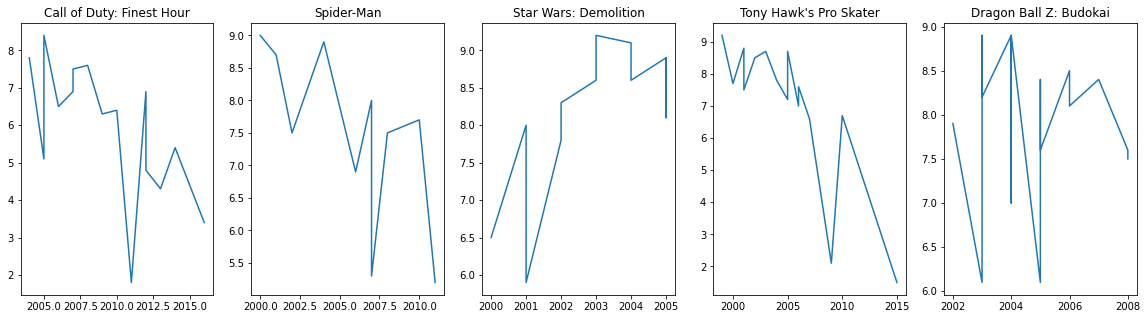

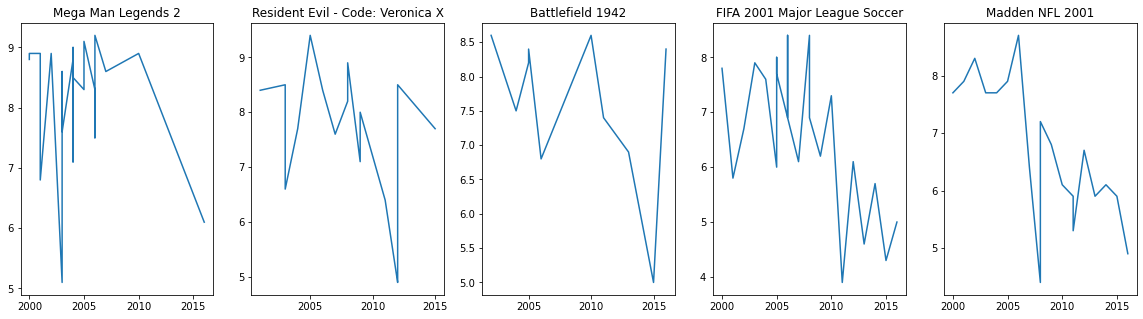

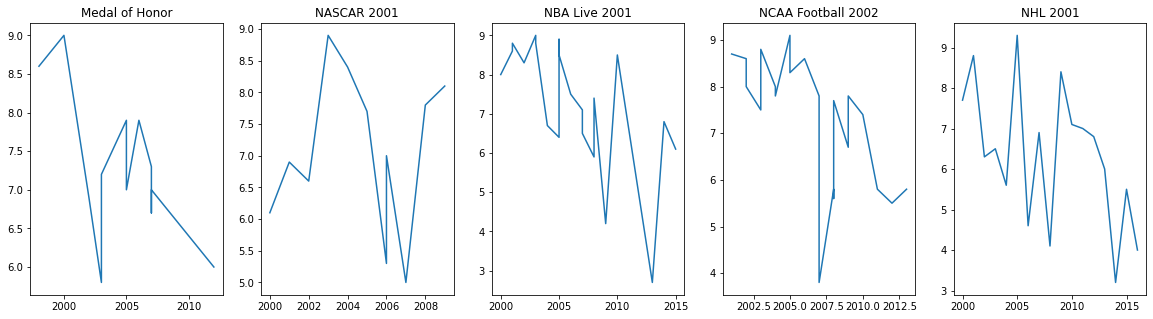

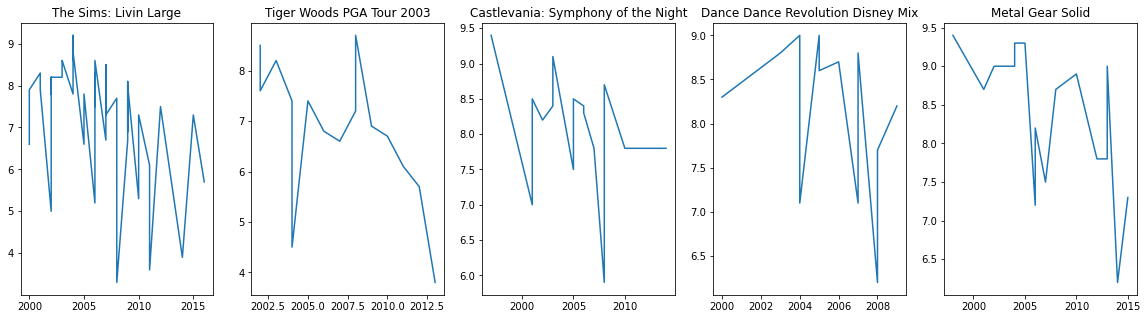

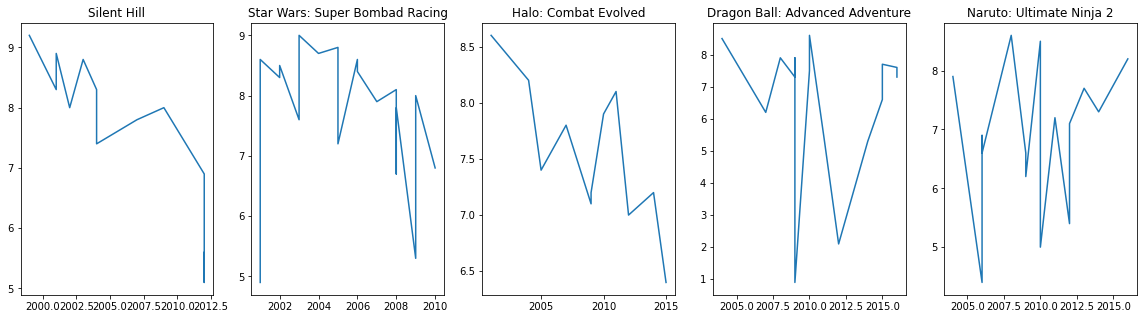

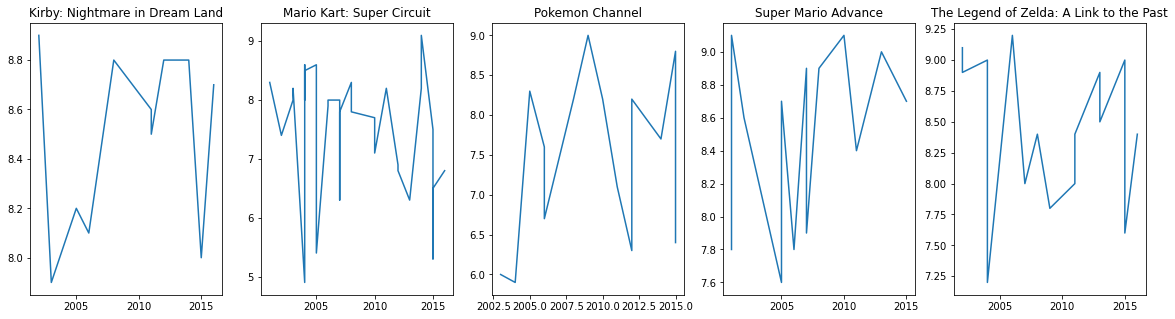

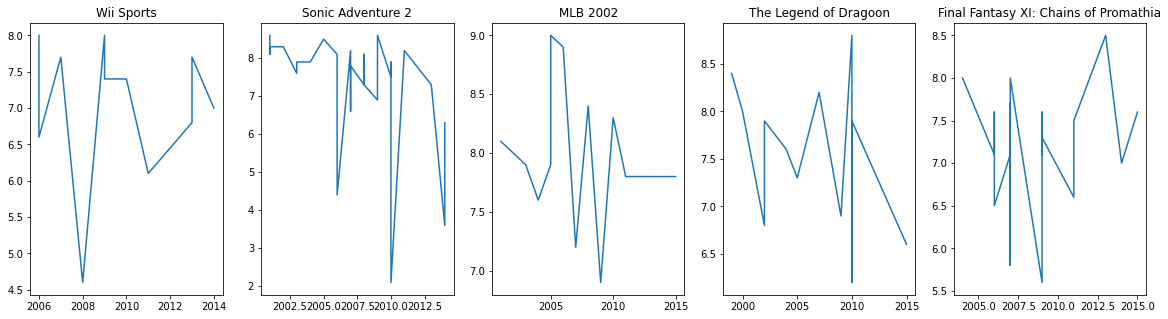

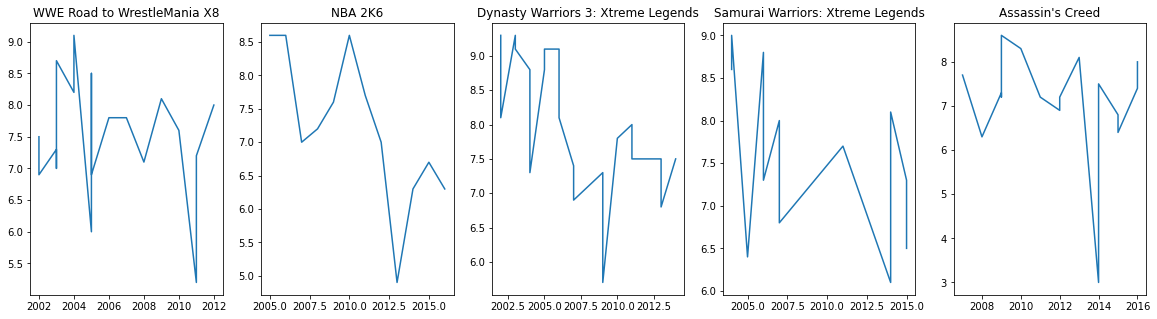

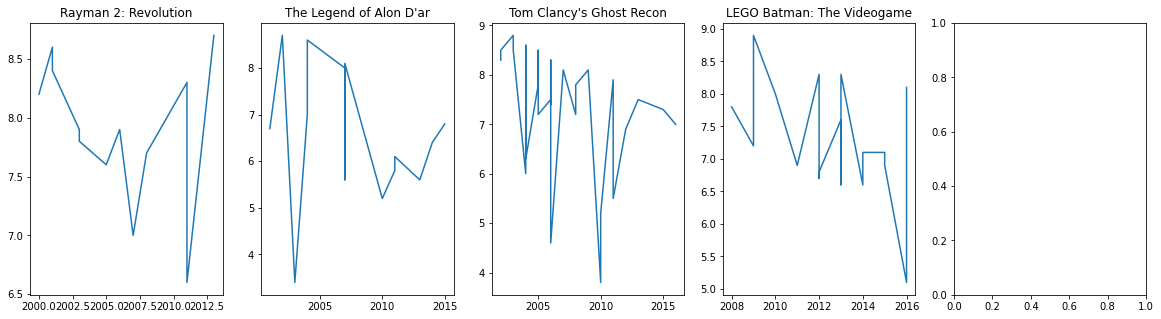

In [133]:
# count of games having more than θ versions
count = 0
for k, v in d_users.items():
    if len(v[0]) > θ:
        count += 1
print(count)

# plot years vs ratings for all games having more than θ versions, each 5 games in a figure
i = 0
_, ax = plt.subplots(1, σ , figsize=(20, 5))
for k, v in d_users.items():
    if len(v[0]) > θ:
        ax[i].plot(v[1], v[0])
        ax[i].set_title(k)
        i += 1
        if i % σ == 0:
            plt.show()
            _, ax = plt.subplots(1, σ , figsize=(20, 5))
            i = 0


44


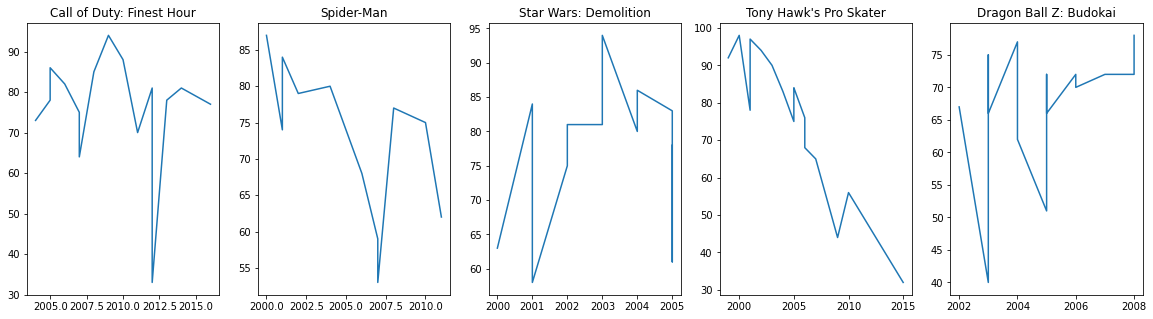

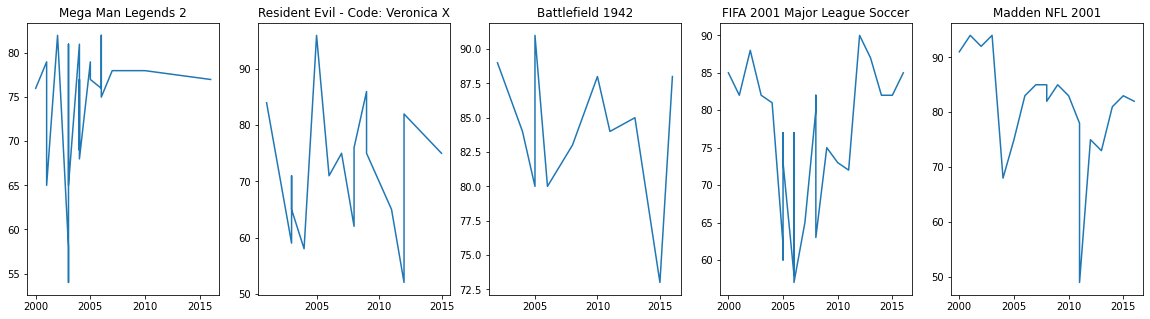

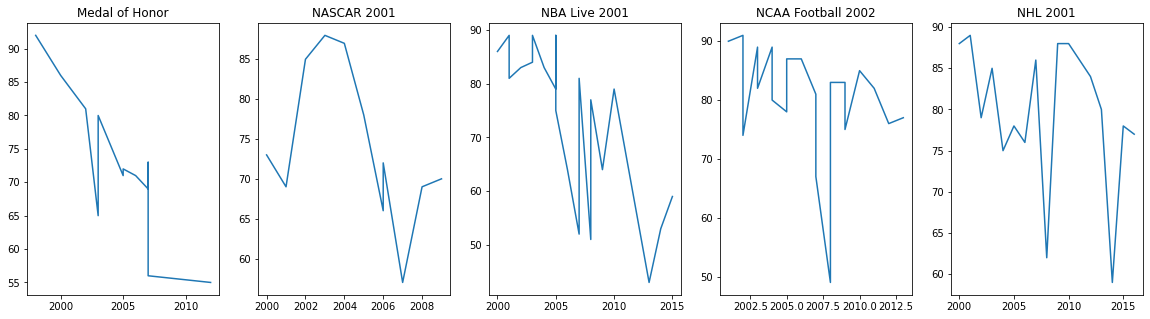

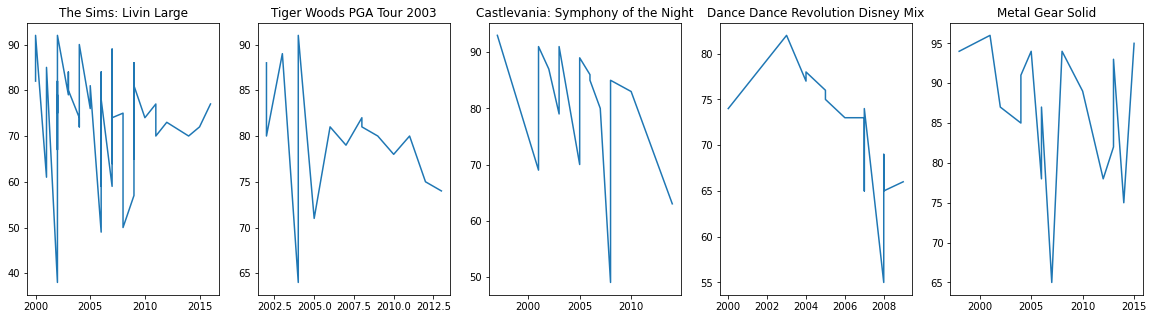

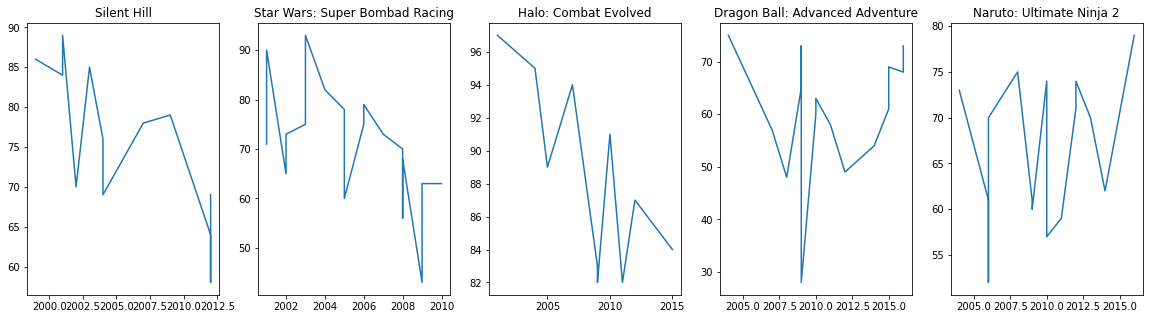

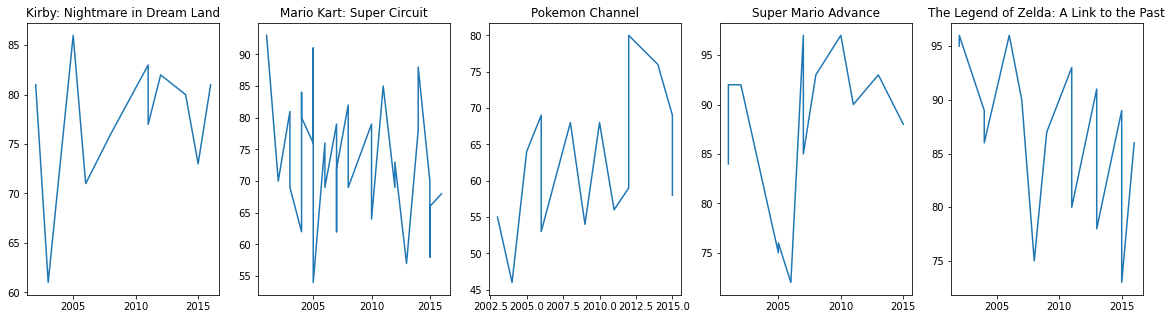

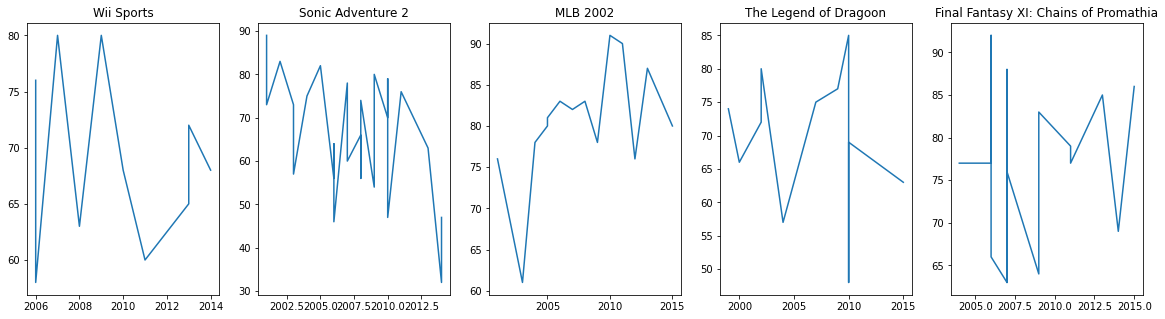

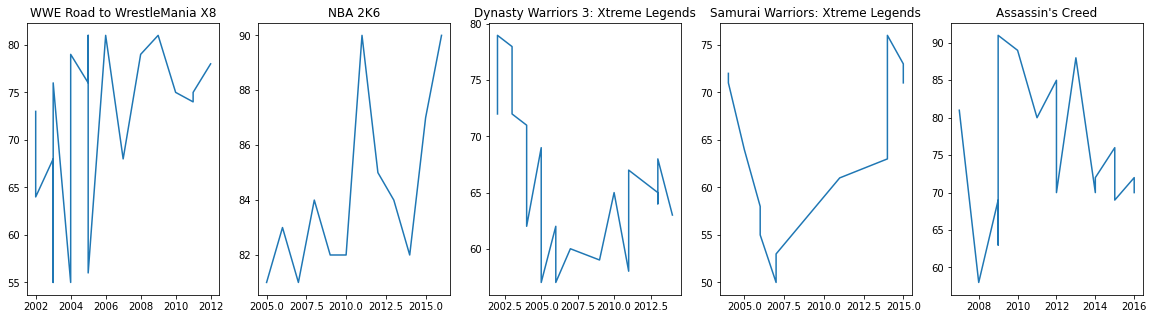

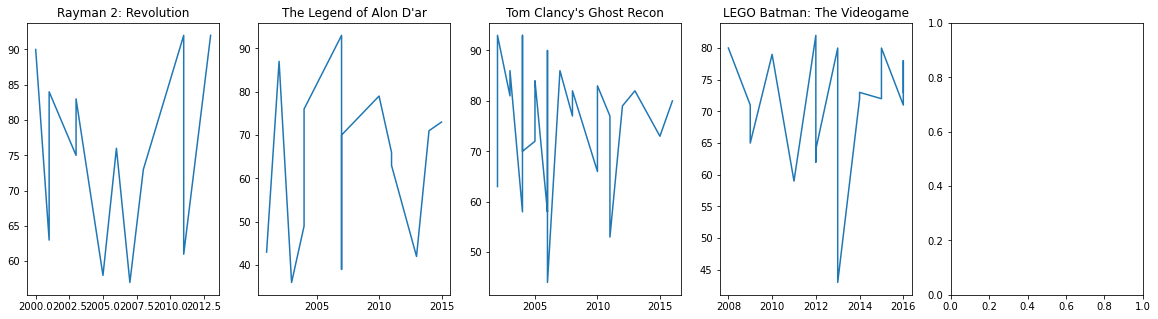

In [134]:
# critics scores
count = 0
for k, v in d_critics.items():
    if len(v[0]) > θ:
        count += 1
print(count)


# plot years vs ratings for all games having more than 10 versions, each 5 games in a figure
i = 0
_, ax = plt.subplots(1, σ , figsize=(20, 5))
for k, v in d_critics.items():
    if len(v[0]) > θ:
        ax[i].plot(v[1], v[0])
        ax[i].set_title(k)
        i += 1
        if i % σ == 0:
            plt.show()
            _, ax = plt.subplots(1, σ , figsize=(20, 5))
            i = 0
            

44


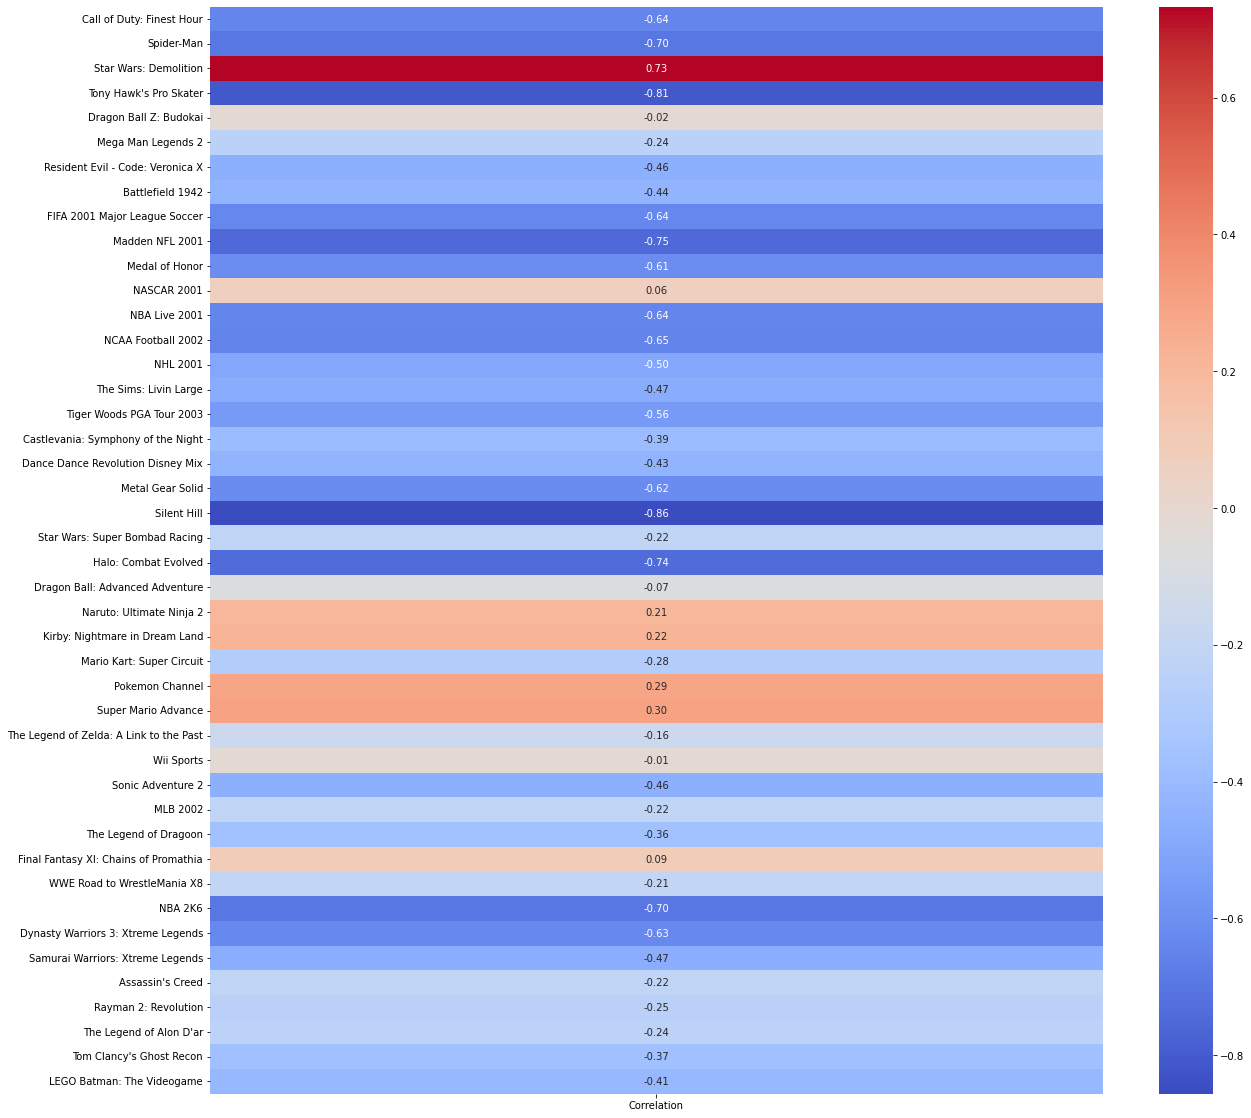

In [135]:
# analytically show if there is a correlation between the year of release and user score (or critic score)
# for each game, compute the correlation between year of release and user score
# first convert the dictionary to a dataframe, filter out games having less than θ versions
# then compute the correlation between year of release and user score
df_users = pd.DataFrame.from_dict(d_users, orient='index', columns=['User_Score', 'Year_of_Release'])
df_users = df_users[df_users['User_Score'].map(len) > θ]
print(len(df_users))
df_users['Correlation'] = df_users.apply(lambda x: np.corrcoef(x['User_Score'], x['Year_of_Release'])[0, 1], axis=1)

# heatmap of correlation between year of release and user score for all games
plt.figure(figsize=(20, 20))
sns.heatmap(df_users['Correlation'].to_frame(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()


In [136]:
# average correlation between year of release and user score for positive correlation
print(df_users[df_users['Correlation'] > 0]['Correlation'].mean())

# average correlation between year of release and user score for negative correlation
print(df_users[df_users['Correlation'] < 0]['Correlation'].mean())


0.2727526234150287
-0.4445557036639504


# Hypohesis testing
### Null Hypothesis: 
        there is no correlation between year of release and user score for a specific game

### Alternative Hypothesis:
        there is a correlation between year of release and user score for a specific game
        

In [137]:
α = 0.05 # significance level

In [151]:
# stats
# null hypothesis: there is no correlation between year of release and user score
# alternative hypothesis: there is a correlation between year of release and user score
import scipy.stats as stats
# correlation between year of release and user score for all games
pos_corr_cnt = 0
neg_corr_cnt = 0
print("Games having more than 10 versions, with correlation between year of release and user score")
print("-----------------------------------")
for k, v in d_users.items():
    if len(v[0]) > 2:  
        corr, p = stats.pearsonr(v[0], v[1])
        if len(v[0]) > θ and p < α:
                print('Game: ', k, 'Correlation: ', corr, 'p-value: ', p)

        if corr > 0:
            pos_corr_cnt += 1
        else:
            neg_corr_cnt += 1

print('-----------------------------------')
print('pos_corr_cnt, neg_corr_cnt')
print(pos_corr_cnt, neg_corr_cnt)
print('percentage of positive correlation')
print(pos_corr_cnt / (pos_corr_cnt + neg_corr_cnt))
print('percentage of negative correlation')
print(neg_corr_cnt / (pos_corr_cnt + neg_corr_cnt))
# percentage of correlated games to all games
print('percentage of correlated games to all games')
print((pos_corr_cnt + neg_corr_cnt) / len(d_users))


Games having more than 10 versions, with correlation between year of release and user score
-----------------------------------
Game:  Call of Duty: Finest Hour Correlation:  -0.6438614061601242 p-value:  0.009589901422744952
Game:  Spider-Man Correlation:  -0.696598790829873 p-value:  0.017233466220270402
Game:  Star Wars: Demolition Correlation:  0.7331900691463025 p-value:  0.006663718318536336
Game:  Tony Hawk's Pro Skater Correlation:  -0.8120269210508245 p-value:  0.00013311704998666943
Game:  FIFA 2001 Major League Soccer Correlation:  -0.6384600330354756 p-value:  0.000786692735509966
Game:  Madden NFL 2001 Correlation:  -0.7471664043860189 p-value:  0.00023670373997000446
Game:  Medal of Honor Correlation:  -0.6098954806345512 p-value:  0.03522688692959433
Game:  NBA Live 2001 Correlation:  -0.6410878751098653 p-value:  0.0023186489661288865
Game:  NCAA Football 2002 Correlation:  -0.647890848948803 p-value:  0.0011126991256521957
Game:  NHL 2001 Correlation:  -0.4999896190395

g:\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


44


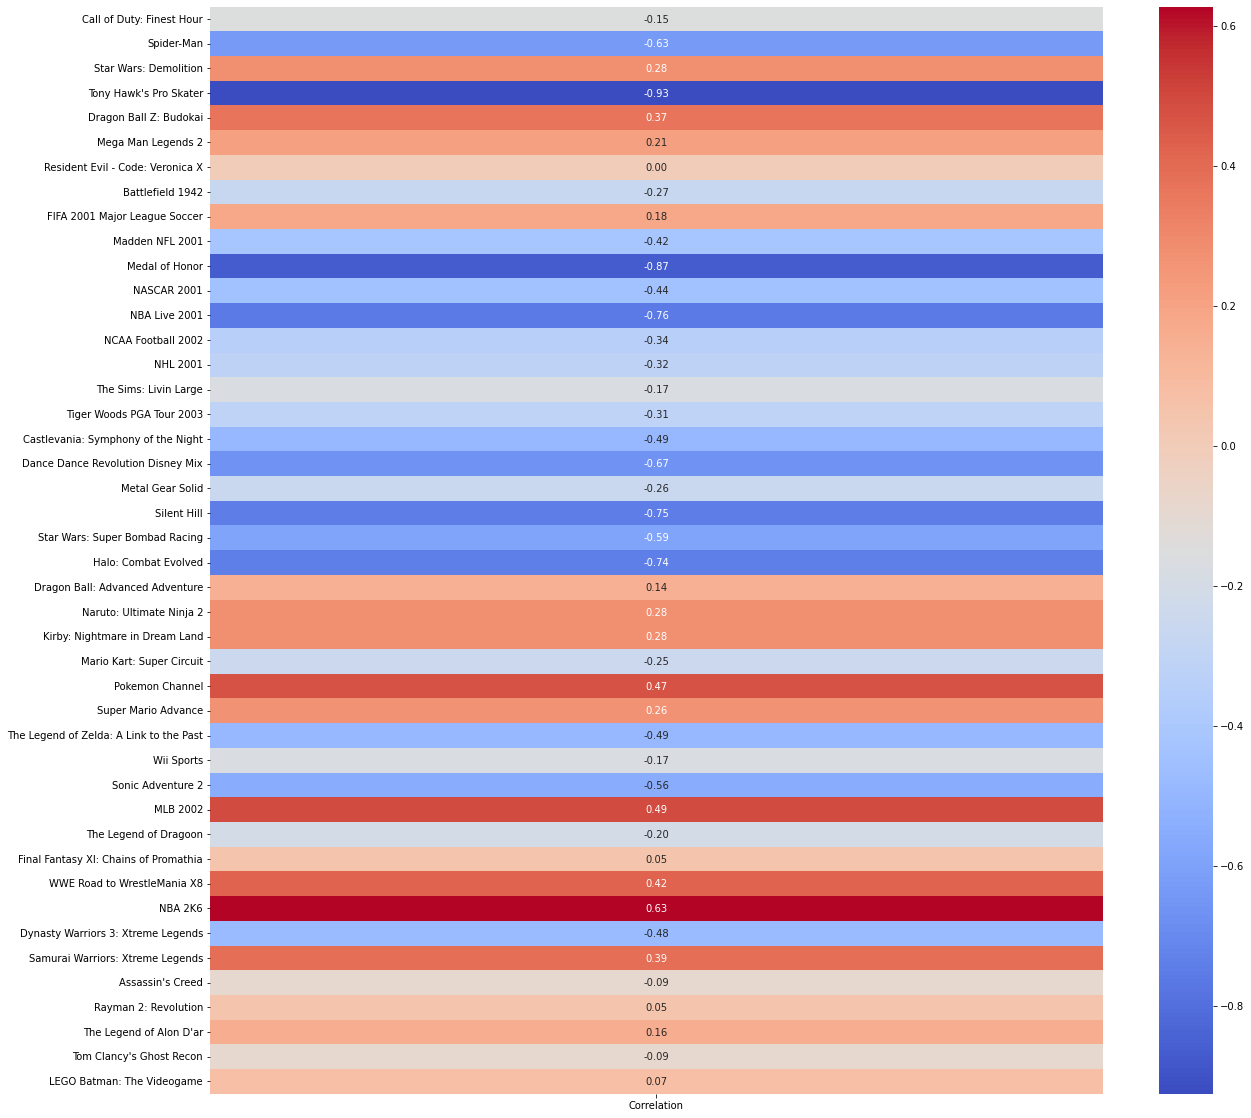

0.26316246662438186
-0.44012983439490905


In [139]:
# critic scores vs year of release
df_critics = pd.DataFrame.from_dict(d_critics, orient='index', columns=['Critic_Score', 'Year_of_Release'])
df_critics = df_critics[df_critics['Critic_Score'].map(len) > θ]
print(len(df_critics))
df_critics['Correlation'] = df_critics.apply(lambda x: np.corrcoef(x['Critic_Score'], x['Year_of_Release'])[0, 1], axis=1)

# heatmap of correlation between year of release and critic score for all games
plt.figure(figsize=(20, 20))
sns.heatmap(df_critics['Correlation'].to_frame(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

# average correlation between year of release and critic score for positive correlation
print(df_critics[df_critics['Correlation'] > 0]['Correlation'].mean())

# average correlation between year of release and critic score for negative correlation
print(df_critics[df_critics['Correlation'] < 0]['Correlation'].mean())


In [150]:
# stats
import scipy.stats as stats
# correlation between year of release and critic score for all games
pos_corr_cnt = 0
neg_corr_cnt = 0

print("Games having more than 10 versions, with correlation between year of release and critic score")
print("-----------------------------------")

for k, v in d_critics.items():
    if len(v[0]) > 2:  
        corr, p = stats.pearsonr(v[0], v[1])
        if len(v[0]) > θ and p < α:
            print('Game: ', k, 'Correlation: ', corr, 'p-value: ', p)
        if corr > 0:
            pos_corr_cnt += 1
        else:
            neg_corr_cnt += 1

print('-----------------------------------')

print('pos_corr_cnt, neg_corr_cnt')
print(pos_corr_cnt, neg_corr_cnt)
print('percentage of positive correlation')
print(pos_corr_cnt / (pos_corr_cnt + neg_corr_cnt))
print('percentage of negative correlation')
print(neg_corr_cnt / (pos_corr_cnt + neg_corr_cnt))
# percentage of correlated games to all games
print('percentage of correlated games to all games')
print((pos_corr_cnt + neg_corr_cnt) / len(d_critics))




Games having more than 10 versions, with correlation between year of release and critic score
-----------------------------------
Game:  Spider-Man Correlation:  -0.6296197345175191 p-value:  0.03790375016151621
Game:  Tony Hawk's Pro Skater Correlation:  -0.9258917991878831 p-value:  2.701675518669078e-07
Game:  Medal of Honor Correlation:  -0.8709340051602876 p-value:  0.0002262169112192745
Game:  NBA Live 2001 Correlation:  -0.7598419568359265 p-value:  0.00010151468567413592
Game:  Dance Dance Revolution Disney Mix Correlation:  -0.6698401245318069 p-value:  0.008771530043401615
Game:  Silent Hill Correlation:  -0.7495504653386555 p-value:  0.005005215315859547
Game:  Star Wars: Super Bombad Racing Correlation:  -0.5889819294367177 p-value:  0.00797021668638911
Game:  Halo: Combat Evolved Correlation:  -0.7419015847834399 p-value:  0.008948485896101295
Game:  Sonic Adventure 2 Correlation:  -0.5552282370035784 p-value:  0.0032366202136705096
Game:  NBA 2K6 Correlation:  0.627488737

g:\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


---------------------------------

## 3- Comparing Expectations to data:
        We see that only few games (13% of the games) have a correlation (positive or negative) between year of release and user score. And thus, we can't reject the null hypothesis. This means that there is no correlation between year of release and user score for a most games.
